# Visualization of estimated DNA movement

In this notebook, we load the h5 file containing the results and generate visualization.

In [1]:
%load_ext autoreload
%autoreload 2

Load the results

In [2]:
from pathlib import Path
import motionquant as mq
import matplotlib.pyplot as plt

# define the path to the result folder
dst = Path('./')
# define the result file
filename = dst / "results.h5"
# check the content of the file
items = mq.inspect_result(filename)
print(f"There are {len(items)} items in '{filename}'.")

There are 62 items in 'results.h5'.


In [ ]:
import pandas as pd
df = pd.read_csv(dst/'results.csv',index_col=0)
df.head()

Make a figure with all the sequences.

Text(0.5, 0.98, '01a_DSM639_SyS_CM_Cell_9')

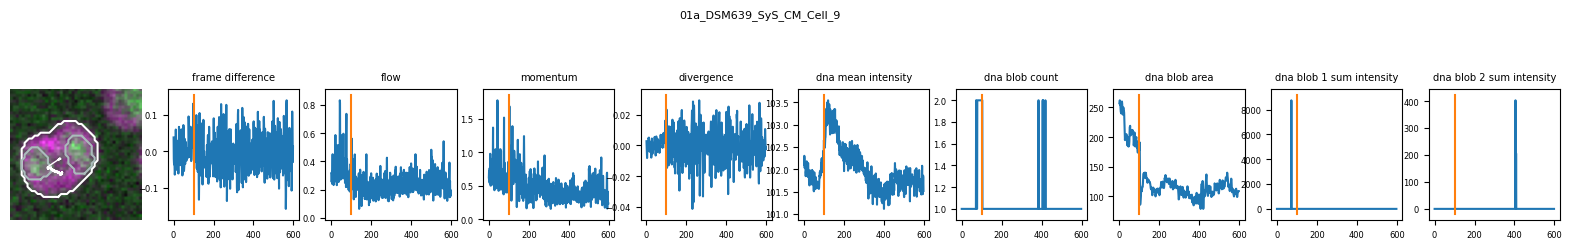

In [3]:
plt.rc('font', size=6)
mq.figure(filename, items[10], frame=100)
plt.suptitle(items[10],fontsize=8)

Save figures in a multipage pdf

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

plt.rc('font', size=6)
with PdfPages('figures.pdf') as pdf:
    for name in items:
        plt.clf()
        mq.figure(filename, name, frame=100)
        plt.suptitle(name,fontsize=8)
        pdf.savefig()
        plt.close()

In [ ]:
img, cell_mask,cell_trj, diff, flow, rho, div, blob_labels, blob_trj = mq.load_result(filename, items[10])
blob_labels[0].max()

In [ ]:
name

In [ ]:
import numpy as np
for k in range(5):
    y = (blob_labels==k).sum(axis=(1,2))
    print(k,np.sum(y>0))
    plt.plot(y)

Inspect a single strip

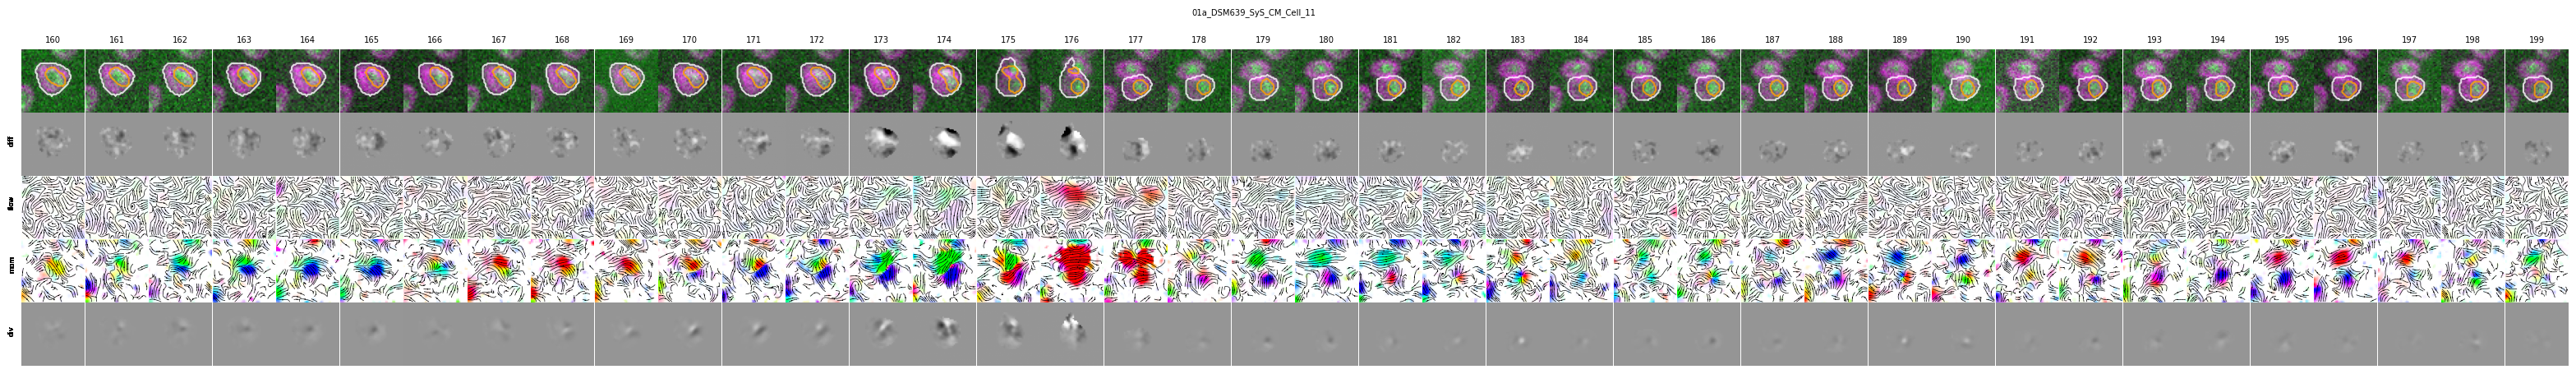

In [4]:
name = items[10]
mq.strip(filename, name, "Greys", selection=slice(160,200,1), quiver=False)


Save all strips as individual pdf files

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

plt.rc('font', size=6)
with PdfPages('strip.pdf') as pdf:
    for name in items:
        plt.clf()
        mq.strip(filename, name, frame=100)
        plt.suptitle(name,fontsize=8)
        pdf.savefig()
        plt.close()

In [ ]:
for name in items:
    plt.clf()
    img, mask, position, speed, diff, flow, rho, div, blob = mq.load_result(filename, name)
    mq.strip(
        name,
        img,
        mask,
        position,
        speed,
        diff,
        flow,
        rho,
        div,
        blob,
        "Greys",
        selection=slice(0,300,20),
        quiver=False,
    )    
    plt.savefig(f"strip {name}.pdf")

Visualize the image and mask using napari

In [ ]:
import napari
vector = mq.make_vector(rho,4)
v = napari.view_image(img, channel_axis=1)
v.add_labels(mask.squeeze())
v.add_vectors(vector, edge_width=0.1, edge_color="white", length=1)

### Massage the csv file

In [ ]:
import pandas as pd
df = pd.read_csv('results.csv',index_col=0)

Save all results to a excel file

In [ ]:
with pd.ExcelWriter('sheets.xlsx') as writer:
    for tab in df.columns[6:]:
        tmp = df.pivot_table(values=tab, index='frame', columns='filename')
        tmp.to_excel(writer,sheet_name=tab)

Use seaborn to create a figure

In [ ]:
dflong = pd.melt(df.iloc[0:1200], id_vars=('filename','frame') , value_vars=df.columns[6:])
dflong.head()

In [ ]:
import seaborn as sns
grid = sns.FacetGrid(data=dflong, row='filename', col='variable', sharey = False)
grid.map_dataframe(sns.lineplot, x="frame",y="value")
# grid.set_titles(template="", row_template='{row_var}{row_name}',col_template='{col_var}{col_name}')
grid.set_titles("", col_template='{col_name}')

In [ ]:
facet_kws={'sharey': False, 'sharex': True}
sns.relplot(data=dflong, x="frame", y="value", col="filename", row="variable", kind='line', facet_kws=facet_kws)